### Edgar Moises Hernandez-Gonzalez
#### 18/04/20-20/04/20
#### Clasificacion de imagenes motoras en EEG con CNN-2D
##### Caracteristicas = Escalogramas CWT (3D)
##### Concatenacion vertical
##### Resize proporcional de 352x62
##### 5 ejecuciones independientes

In [0]:
from google.colab import drive

In [0]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import cohen_kappa_score, confusion_matrix
import pywt
import cv2
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras import backend as K

Using TensorFlow backend.


In [0]:
# para que este script funcione debe de decir 'channels_last', si dice 'channels_first' no sirve
K.image_data_format()

'channels_last'

In [0]:
x_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/Ventaneo-A01T.csv", header=None)
x_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/Ventaneo-A01E.csv", header=None)
y_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/EtiquetasVentaneo-A01T.csv", header=None)
y_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/EtiquetasVentaneo-A01E.csv", header=None)

In [0]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(6048, 11000)
(6048, 11000)
(6048, 1)
(6048, 1)


In [0]:
n_samples_train = len(y_train)
n_samples_test = len(y_test) #en caso de no tener el y_test se puede utilizar el x_test

print("n_samples_train:", n_samples_train)
print("n_samples_test :", n_samples_test)

n_samples_train: 6048
n_samples_test : 6048


In [0]:
n_classes = len(np.unique(y_test)) #esto se podria calcular asi n_clases = len(np.unique(y)), la y puede ser train o test

print("n_classes:", n_classes)

n_classes: 4


In [0]:
#codificar etiquetas con valores de 0 a nClases-1
#le = LabelEncoder().fit(y_train)
#y_train = le.transform(y_train)
#y_test = le.transform(y_test)

In [0]:
#unir 22 canales
def unir_escalogramas_vertical_resize(data):
  escalas = np.arange(1,129)
  dim = (62, 352) #ancho, alto
  datos = np.zeros((6048,352,62))
  temporal = np.zeros((2816,500))
  for i in range(data.shape[0]): #6048 muestras
    for j in range(22): #22 canales
      sig = data.iloc[i, j*500:(j+1)*500]
      coef, freqs = pywt.cwt(sig, escalas, 'cmor3-3') #escalograma CWT
      temporal[j*128:(j+1)*128, :] = abs(coef)
    resized = cv2.resize(temporal, dim, interpolation=cv2.INTER_AREA)
    datos[i] = resized
    if i % 100 == 0: #esto solo es para ver como avanza
      print(i)
  return datos

In [0]:
#llamar a escalogramas(data)
#primero x_train para no acabarse la RAM
x_train = unir_escalogramas_vertical_resize(x_train)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000


In [0]:
from google.colab import files

In [0]:
np.savez_compressed('x_trainA01T.npz', x_train)

In [0]:
# pesa 964mb por lo tanto no es practico usar ventaneo para CWT
#files.download('x_trainA01T.npz')

In [0]:
#llamar a escalogramas(data)
#despues x_test para no acabarse la RAM
x_test = unir_escalogramas_vertical_resize(x_test)

In [0]:
print(x_train.shape)
print(x_test.shape)

(6048, 352, 62)
(6048, 352, 62)


In [0]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))
print(np.mean(x_train))
print(np.mean(x_test))

61.44195678982832
55.95270140093569
0.0015741318929519072
0.0014695295012428222
3.7711482092387025
3.675984998574758


In [0]:
#convertir a float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#escalar los valores en un rango de 0 a 1 (normalizar)
x_train /= 62.0
x_test /= 62.0

NameError: ignored

In [0]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))
print(np.mean(x_train))
print(np.mean(x_test))

0.9909993
0.9024629
2.5389225e-05
2.3702089e-05
0.060824994
0.059290085


In [0]:
#convertir de 3D a 4D
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))

print(x_train.shape)
print(x_test.shape)

(6048, 352, 62, 1)
(6048, 352, 62, 1)


In [0]:
def CNN_2D():
  model = Sequential()
  model.add(Conv2D(8, (3,3), activation='relu', input_shape=x_train.shape[1:]))
  model.add(MaxPool2D((2,2)))
  model.add(Conv2D(8, (3,3), activation='relu'))
  model.add(MaxPool2D((2,2)))
  model.add(Conv2D(8, (3,3), activation='relu'))
  model.add(MaxPool2D((2,2)))
  model.add(Flatten())
  model.add(Dense(16, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-4)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model

Iteration: 1
Train on 6048 samples, validate on 6048 samples
Epoch 1/400
 - 11s - loss: 1.3756 - accuracy: 0.2758 - val_loss: 1.3507 - val_accuracy: 0.3228
Epoch 2/400
 - 4s - loss: 1.2937 - accuracy: 0.3995 - val_loss: 1.2296 - val_accuracy: 0.4358
Epoch 3/400
 - 4s - loss: 1.2072 - accuracy: 0.4368 - val_loss: 1.1666 - val_accuracy: 0.4554
Epoch 4/400
 - 4s - loss: 1.1499 - accuracy: 0.4721 - val_loss: 1.1136 - val_accuracy: 0.4841
Epoch 5/400
 - 4s - loss: 1.0987 - accuracy: 0.4969 - val_loss: 1.0661 - val_accuracy: 0.5084
Epoch 6/400
 - 5s - loss: 1.0469 - accuracy: 0.5266 - val_loss: 1.0523 - val_accuracy: 0.5084
Epoch 7/400
 - 5s - loss: 1.0119 - accuracy: 0.5428 - val_loss: 1.0038 - val_accuracy: 0.5200
Epoch 8/400
 - 4s - loss: 0.9680 - accuracy: 0.5630 - val_loss: 0.9796 - val_accuracy: 0.5322
Epoch 9/400
 - 4s - loss: 0.9376 - accuracy: 0.5780 - val_loss: 0.9631 - val_accuracy: 0.5374
Epoch 10/400
 - 5s - loss: 0.9069 - accuracy: 0.5880 - val_loss: 0.9300 - val_accuracy: 0.56

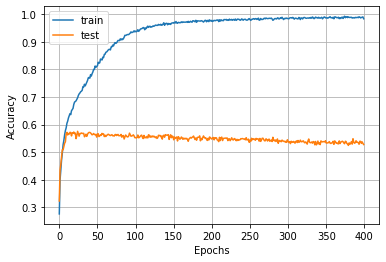

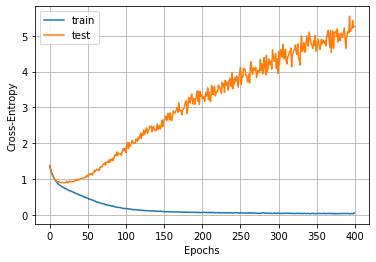

Iteration: 2
Train on 6048 samples, validate on 6048 samples
Epoch 1/400
 - 5s - loss: 1.3760 - accuracy: 0.2837 - val_loss: 1.3443 - val_accuracy: 0.4392
Epoch 2/400
 - 4s - loss: 1.2987 - accuracy: 0.3965 - val_loss: 1.2202 - val_accuracy: 0.4320
Epoch 3/400
 - 4s - loss: 1.2083 - accuracy: 0.4413 - val_loss: 1.1391 - val_accuracy: 0.4820
Epoch 4/400
 - 4s - loss: 1.1533 - accuracy: 0.4777 - val_loss: 1.0977 - val_accuracy: 0.4980
Epoch 5/400
 - 4s - loss: 1.1054 - accuracy: 0.4897 - val_loss: 1.0506 - val_accuracy: 0.5050
Epoch 6/400
 - 4s - loss: 1.0632 - accuracy: 0.5121 - val_loss: 1.0348 - val_accuracy: 0.4901
Epoch 7/400
 - 4s - loss: 1.0212 - accuracy: 0.5324 - val_loss: 1.0135 - val_accuracy: 0.5103
Epoch 8/400
 - 4s - loss: 0.9875 - accuracy: 0.5574 - val_loss: 0.9705 - val_accuracy: 0.5476
Epoch 9/400
 - 4s - loss: 0.9557 - accuracy: 0.5691 - val_loss: 0.9532 - val_accuracy: 0.5405
Epoch 10/400
 - 4s - loss: 0.9329 - accuracy: 0.5774 - val_loss: 0.9498 - val_accuracy: 0.538

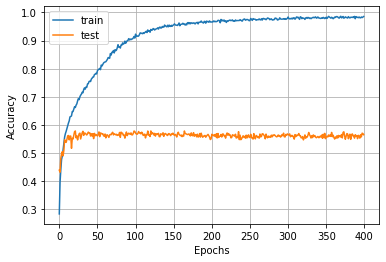

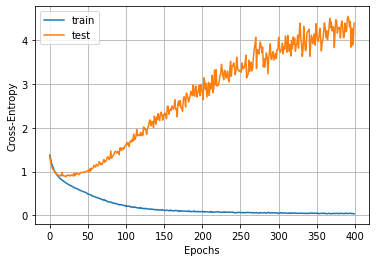


Resultados:
loss: [5.258996020554116, 4.38798269764126]
accuracy: [0.5274471044540405, 0.5653108358383179]
kappa: [0.3699294532627866, 0.42041446208112876]


In [0]:
array_loss = []
array_acc = []
array_kappa = []
for i in range(5):
  print("Iteration:", i+1)
    
  model = CNN_2D()

  history = model.fit(x_train, y_train, epochs=400, batch_size=512,
                      validation_data=(x_test, y_test), verbose=0)
    
  test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
  array_loss.append(test_loss)
  print("loss: ", test_loss)
  array_acc.append(test_acc)
  print("accuracy: ", test_acc)
    
  probabilidades = model.predict(x_test)
  y_pred = np.argmax(probabilidades, 1) #1=fila
    
  kappa = cohen_kappa_score(y_test, y_pred)
  array_kappa.append(kappa)
  print("kappa: ", kappa)
    
  matriz_confusion = confusion_matrix(y_test, y_pred)
  print("confusion matrix:\n", matriz_confusion)
    
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'test'])
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy')
  plt.legend(['train', 'test'])
  plt.show()
    
print() 
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
print("kappa:", array_kappa)

In [0]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 350, 60, 8)        80        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 175, 30, 8)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 173, 28, 8)        584       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 86, 14, 8)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 84, 12, 8)         584       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 42, 6, 8)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2016)             

In [0]:
print("Mean Accuracy: %.4f" % np.mean(array_acc))
print("std: (+/- %.4f)" % np.std(array_acc))
print("Mean Kappa: %.4f" % np.mean(array_kappa))
print("std: (+/- %.4f)" % np.std(array_kappa))
print("Max Accuracy: %.4f" % np.max(array_acc))
print("Max Kappa: %.4f" % np.max(array_kappa))

Mean Accuracy: 0.5464
std: (+/- 0.0189)
Mean Kappa: 0.3952
std: (+/- 0.0252)
Max Accuracy: 0.5653
Max Kappa: 0.4204
